<a href="https://colab.research.google.com/github/zberis/DSPS_ZBeris/blob/main/HW6/Copy_of_Second_Half_fitlinetogrbafterglow_mcmc_instructions_dsps25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pylab as plt
import emcee #import the package - please move this to the top with the other imports!
# you will need more imports, put them here


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.1 MB/s eta 0:00:00


# HW part 1

## Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
# data is called grb050525A.csv in the data folder in the DSPS_FBianco repo
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/refs/heads/main/data/grb050525A.csv")
grbAG.head()


,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


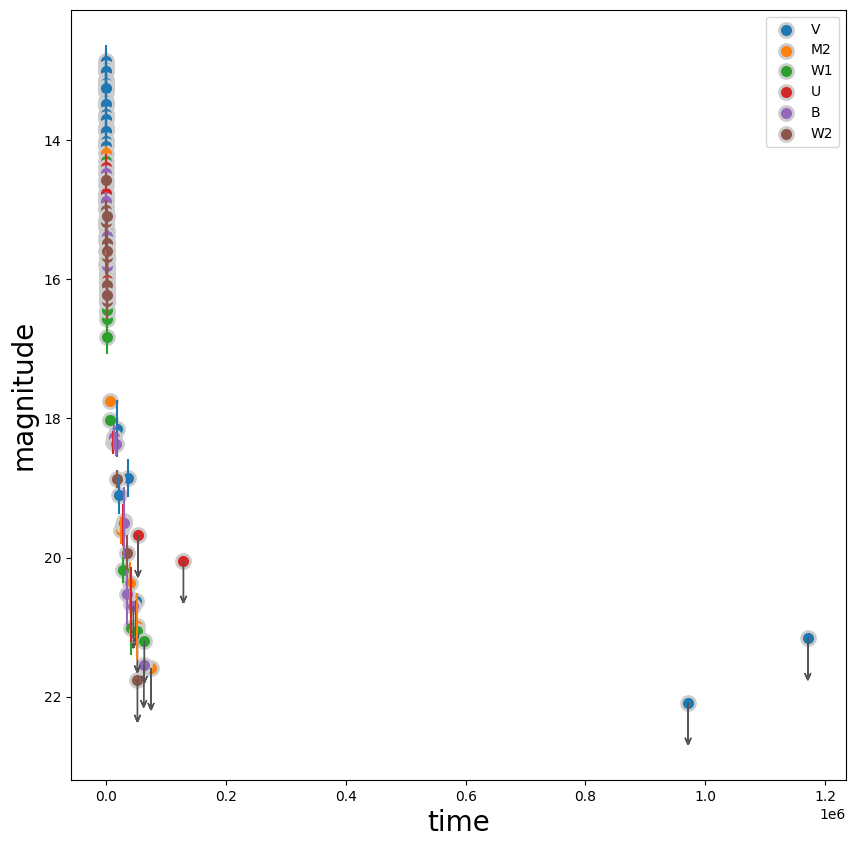

In [3]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
#pl.ylim(24,11.7) #simpler, less elegant - still does the trick
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

## Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [4]:
grbAG["logtime"] = np.log10(grbAG["time"])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [5]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

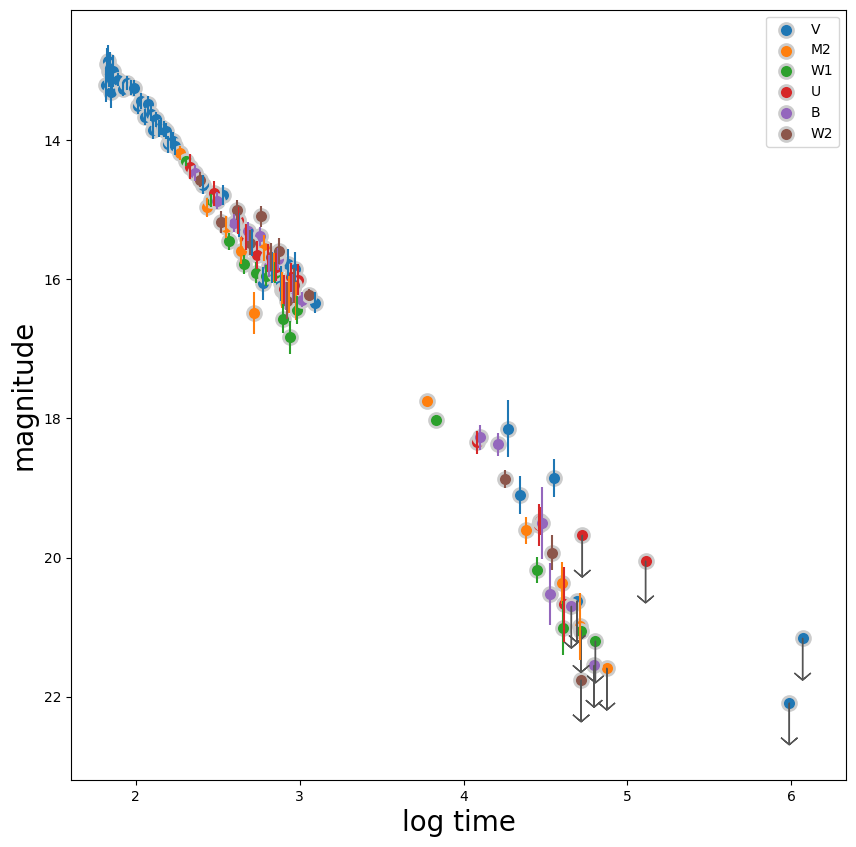

In [6]:
plotlogtime(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

## Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [7]:
grbAGnouplim =  grbAG[grbAG["upperlimit"] == 0]# remove the upper limits from the dataframe to simplify the analysis

In [8]:
x = grbAGnouplim.logtime.values
#pick a function to expand the axis
#option 1
X = np.c_[np.ones((len(grbAGnouplim), 1)),x]
#option 2 np.dstack((np.ones((X.shape[0])) ,X))


y = grbAGnouplim.mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [9]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [10]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
lr = LinearRegression()
lr.fit(X, y)
print(f"slope {lr.coef_[1]:.2f} and intercept {lr.intercept_:.2f}")

slope 2.51 and intercept 8.58


## Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [11]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(intercept, slope, x):
    '''returns a line
    args:
    intercept: float
    slope: float
    x: array-like of exogenous variables
    '''
    return intercept + slope * x

def l1(args, x, y):
    '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 abs value of difference between prediction and data squared
    '''
    a, b = args
    return np.sum(np.abs(line(a, b, x) - y))


initialGuess = (2, 8)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.30332889501873
        x: [ 8.225e+00  2.641e+00]
      nit: 14
      jac: [-1.254e-01 -2.083e+00]
 hess_inv: [[ 2.054e-02 -4.529e-03]
            [-4.529e-03  1.001e-03]]
     nfev: 300
     njev: 96

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [12]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return np.sum((line(a, b, x) - y)**2)


initialGuess = (2, 8)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725498
        x: [ 8.583e+00  2.512e+00]
      nit: 5
      jac: [-1.192e-07 -3.576e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 21
     njev: 7

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51


## Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [13]:
def chi2(args, x, y, s):
    a, b = args
    return np.sum((line(a, b, x) - y)**2 / s**2)


x = grbAGnouplim.logtime.values
y = grbAGnouplim.mag.values
s = grbAGnouplim.magerr.values

initialGuess = 8, 2

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013056
        x: [ 8.599e+00  2.480e+00]
      nit: 7
      jac: [-1.907e-05 -1.526e-05]
 hess_inv: [[ 3.314e-03 -2.853e-03]
            [-2.853e-03  2.473e-03]]
     nfev: 125
     njev: 38

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


## Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


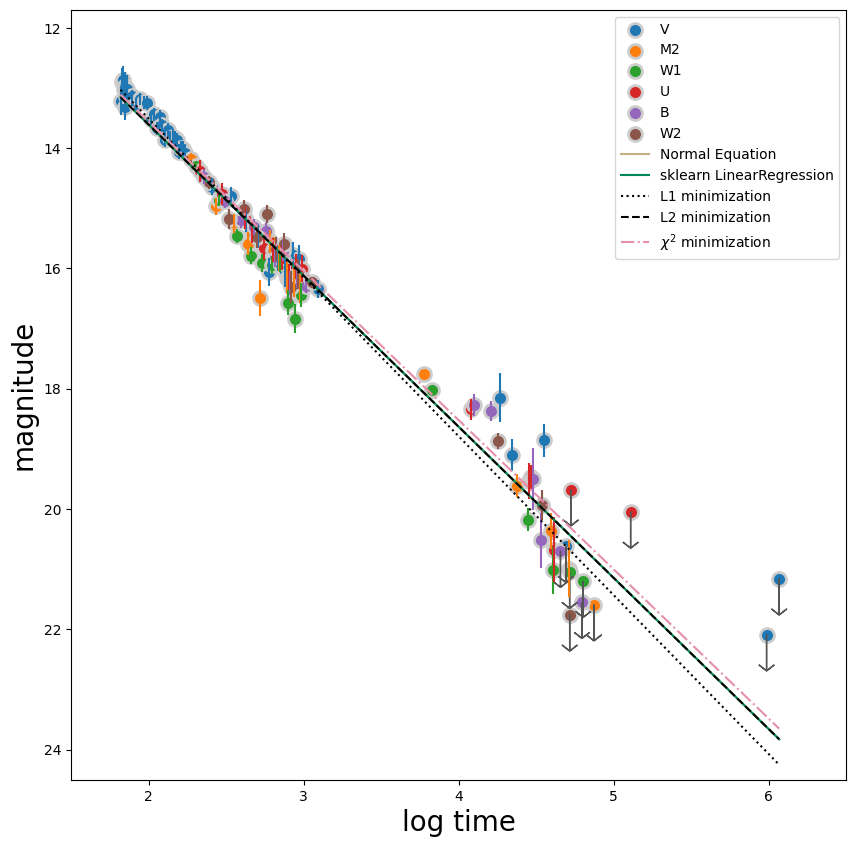

In [14]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 2: This plot is of photometric measurements of GRB 052505A. Each of the datapoints is plotted with its associated error. The different wavelength bands are indicated by different colors, and are labeled in the legend. The points with arrows are the upperlimits of each of the wavelength bands. Several different linear fits were done to this data, using different loss functions. The Normal Equation, sklearn Linear Regressions and L2 minimization produced the same results. The L1 minimization and the $ χ^2 $ produced different results. We can see that the smaller the mangitude, the better the data agrees with the linear fits.

# HW part 2: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((91, 2), (91,), (17, 2), (17,))

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f"score on the training set {lr.score(X_train, y_train):.2f}")
print(f"score on the training set {lr.score(X_test, y_test):.2f}")

score on the training set 0.98
score on the training set 0.94


The score is the same for the training and test set. This means that we are not overfitting the data and the model is transferable to unseen data. Furthermore the score is high: the model explains 97% of the variance which is remarkably good!

# Now try a line to the data with MCMC

# HW part 3: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [17]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

In [18]:
emcee

<module 'emcee' from '/usr/local/lib/python3.12/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters:

$P(\theta | D) ~ P(D | \theta) * P(\theta)$

or

_Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



# Below i develop the line model and find the posterior with MCMC. Your task is to do the same for a different model. the Broken Power Law

In [19]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [20]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [21]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [22]:
#initial guess
ig = [1,10]

In [23]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [24]:
#the starting point for each walker is a small perturbation of the initial guess
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [25]:
pos.shape

(32, 2)

In [26]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [27]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5_000, progress=True); #progress=True show the dynamic percentage bar

100%|██████████| 5000/5000 [00:14<00:00, 348.27it/s]


In [28]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [29]:
samples.shape

(5000, 32, 2)

In [30]:
samples.transpose(1,0,2)[:,:,0].shape

(32, 5000)

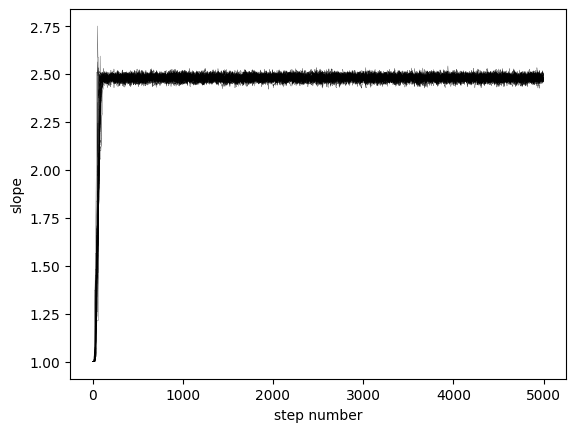

In [31]:
for i in range(ndim):
    pl.plot(samples[:,:,0], 'k', lw=0.1, )

pl.xlabel("step number");
pl.ylabel("slope");


Figure 3: This figure is showing the 32 different walkers of the MCMC, that are sampling the space and trying to find the slope that minimizes the likelihood functions. All of the walkers start around our initial guess. For the first ~100 steps, the 32 walkers are "burning in" and so that part will be discarded when we calculate the best slope value. The walkers all end up around the value of 2.5 .

to get statistical properties of the chains I will concatenate the 32 chains.
This works _iff_ the chains are independent - see about it in the slides!

note: the chains are _assumed_ to be independent


the first 100 points are where the chains are "burning in" and we will throw them away (`discard=100`) - see slides!!
`flat=True` does the concatenation


In [32]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian


In [33]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])

print(f"slope {mcmc[0][1]:.2f} [{mcmc[0][0]:.2f}-{mcmc[0][2]:.2f}]")
print(f"intercept {mcmc[1][1]:.2f} [{mcmc[1][0]:.2f}-{mcmc[1][2]:.2f}]")

slope 2.48 [2.47-2.49]
intercept 8.60 [8.56-8.64]


plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters


In [34]:
!pip install corner


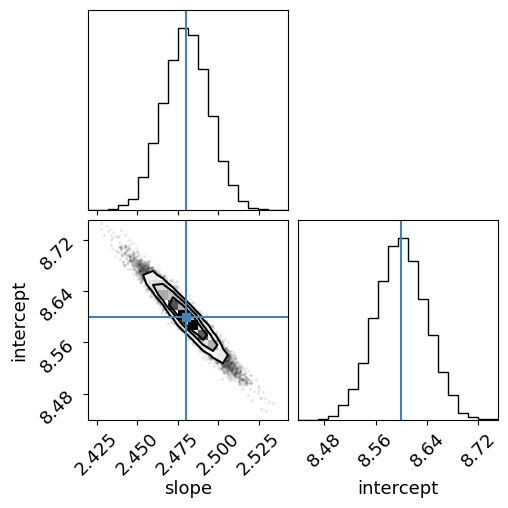

In [35]:
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["slope", "intercept"], truths=mcmc[:,1]);


Figure 4: In this figure we have a 2D projection of the feature space, and 1D marginalization probabilities for intercept and slope, that are generated with data from the MCMC. The 2D projections of the feature space can help us see where it is more likely for the minimized solution to be found. The blue lines represent the most likely solution, the median, for the slope and intercept. In the 2D projection of the feature space, the different ovals represent different percentiles of the distribution, with the one on the outside being 84%, the next one being 50% and the most inner being 16%.

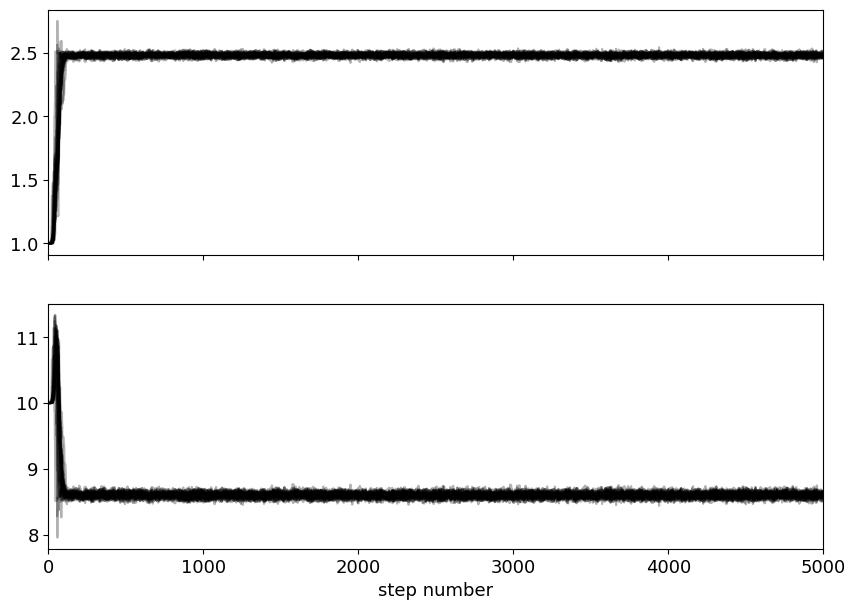

In [36]:
# the chains should be plotted as well. here is a better plot of the chains
#in the slides and in class I discussed what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 5: This figure is again showing the 32 different walkers of the MCMC, that are sampling the space and trying to find the slope that minimizes the likelihood functions. All of the walkers start around our initial guess. For the first ~100 steps, the 32 walkers are "burning in" and so that part will be discarded when we calculate the best slope and intercept value. The upper plot is the same as in figure 3. The upper plot is for the slope and the lower one is for the intercept.

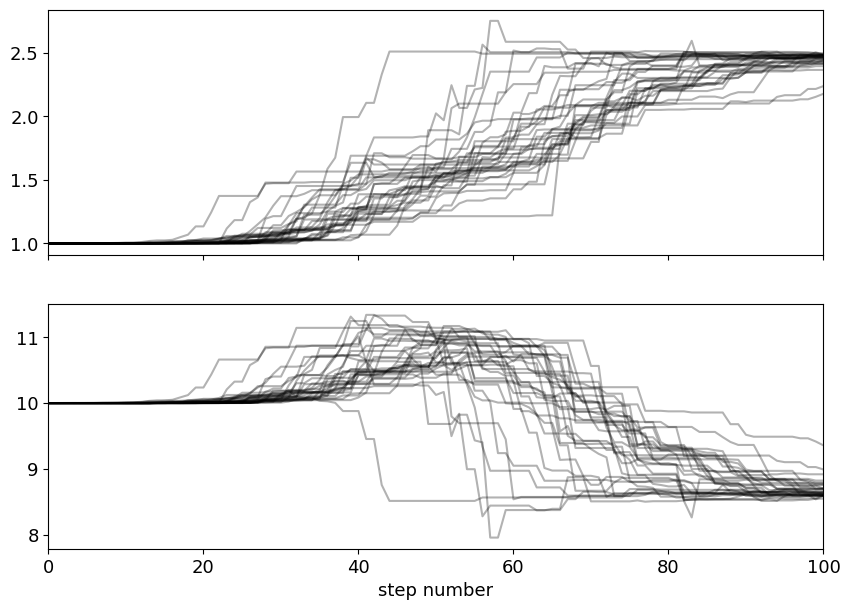

In [37]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 6: This is a plot showing the first 100 values of the MCMC for both the slope and the intercept. We see that the walkers start out at values around the initial value we gave them, and then they start to explore the space and start drifting towards the ebst value for the slope and the intercept. These first 100 steps are the "burning in" steps, and are going to be discarded when we calculate the intercept and slope based on what values the walkers end up being at.

In [38]:
# save the mcmc results for later
mcmc_line = mcmc
mcmc_line

array([[2.46592671, 2.4804137 , 2.49427176],
       [8.56031888, 8.59927998, 8.63916313]])

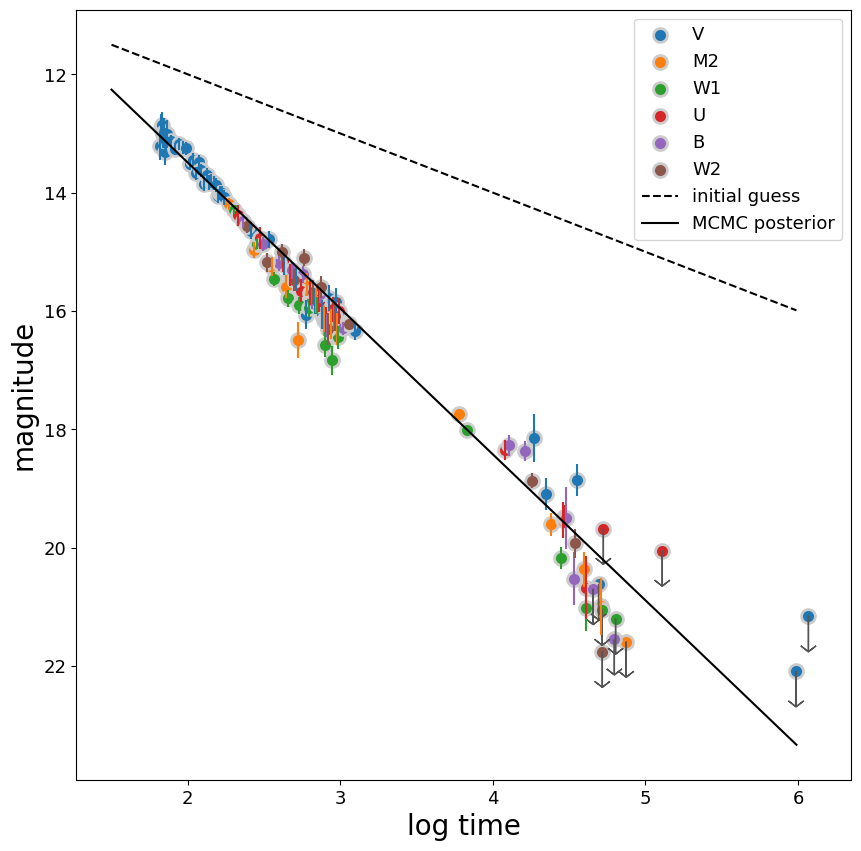

In [39]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01),
        line(10, 1, (np.arange(1.5,6,0.01))),
        #line(ig[1], ig[0], 10**np.arange(1.5,6,0.01)),
        ls="--", c="k",
        label="initial guess")

ax.plot(np.arange(1.5,6,0.01),
        line(mcmc_line[1][0], mcmc_line[0][0], np.arange(1.5,6,0.01)),
        ls="-", c="k",
        label="MCMC posterior")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

#pl.ylim(24.5,11.7)
#pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 7: This plot is of photometric measurements of GRB 052505A. Each of the datapoints is plotted with its associated error. The different wavelength bands are indicated by different colors, and are labeled in the legend. The points with arrows are the upperlimits of each of the wavelength bands. Several different linear fits were done to this data, using different loss functions. The initial guess of a slope of 1 and an intercept of 10 is plotted as a black dashed line. The fit found by the MCMC is plotted as a solid black line. An interesting point to note is that the points at smaller magnitude agree better with the fit compared to the ones with higher magnitude.

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [40]:
# NOTE: this model is not in log time!!
t = grbAGnouplim.time.values

In [41]:
t.min(), t.max()

(np.int64(66), np.int64(51257))

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [42]:
def bpl (theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable (time)
    Return:
      model predictions for each x (array like)
    """
    a1, a2, tb, b = theta
    return b - np.log10(((x/tb)**(-a1) + (x/tb)**(-a2)))



In [43]:
def log_likelihood_bpl(theta, x, y, yerr):
  # use the same log_likelihood as before (chi2) but with the new model
  a1, a2, tb, b = theta
  return -np.sum(((y - bpl(theta, x))**2) / yerr**2)



def log_prior_bpl(theta):
  # similar to before, but choose relevant regions of avoidance based on the description of the model
  a1, a2, tb, b = theta
  if a1 > 0 and a2 > 0 and tb > t.min() and tb < t.max():
    return 0
  return -np.inf

def log_posterior_bpl(theta, x, y, yerr):
  #this is the same as before! exactly! cause this is just log_likelihood + log_prior
  lp = log_prior_bpl(theta)
  if not np.isfinite(lp):
    return -np.inf
  return lp + log_likelihood_bpl(theta, x, y, yerr)


# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [44]:
#I asked gemini what method to use for the minimization as it kept failing, and it suggested teh Nelder-Mead
def log_likelihood_bpl_pos(theta, x, y, yerr):
  # use the same log_likelihood as before (chi2) but with the new model
  a1, a2, tb, b = theta
  return np.sum(((y - bpl(theta, x))**2) / yerr**2)


ig = [.2, 5, 5000, 15] # Updated initial guess
x_nolog = grbAGnouplim.time.values
#what does the minimize function need to take as arguments?
y = grbAGnouplim.mag.values
yerr = grbAGnouplim.magerr.values
soln = minimize(log_likelihood_bpl_pos, ig, args=(x_nolog, y, yerr), method='Nelder-Mead', options={"maxiter" : 20000})
print(soln)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 217.46531455513664
             x: [ 2.146e+00  3.548e+00  2.736e+02  1.505e+01]
           nit: 727
          nfev: 1212
 final_simplex: (array([[ 2.146e+00,  3.548e+00,  2.736e+02,  1.505e+01],
                       [ 2.146e+00,  3.548e+00,  2.736e+02,  1.505e+01],
                       ...,
                       [ 2.146e+00,  3.548e+00,  2.736e+02,  1.505e+01],
                       [ 2.146e+00,  3.548e+00,  2.736e+02,  1.505e+01]]), array([ 2.175e+02,  2.175e+02,  2.175e+02,  2.175e+02,
                        2.175e+02]))


[  2.14569851   3.54797795 273.58198089  15.04714839]


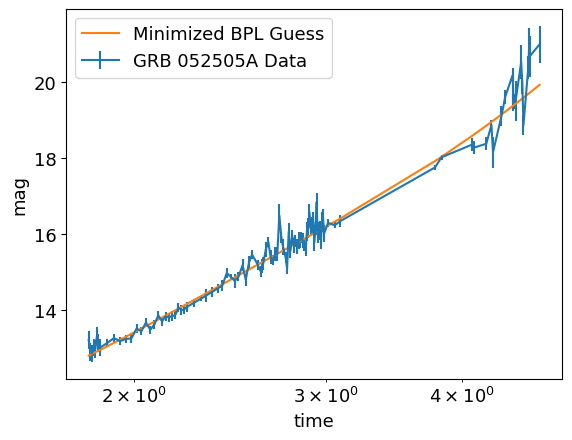

In [63]:
ig = soln.x # the initial guess for the MCMC
print(soln.x)
# plot the model as it looks with the initial guess values
pl.errorbar(x, y, yerr=s, label = "GRB 052505A Data")
pl.plot(x, bpl(ig, x_nolog), label = "Minimized BPL Guess")
pl.legend()
pl.xscale("log");
pl.xlabel("time");
pl.ylabel("mag");

Figure 8: This is a plot of the GRB 052505A data with a fitted BPL model, minimized using the Nelder-Mead method, as when we didn't pass a method, the minimization would fail, and Nelder-Mead works well for non linear optimization problems. As we can see on a qualitative level, even with the initial solution from minimization we get a model that fits the early data well, and the later data better than what the linear fit did.




# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [46]:
# set the emcee hyperparameters
np.random.seed(774119808)
nwalkers, ndim = 32, 4

pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(x_nolog, y, yerr))

In [47]:
# run the model
sampler.run_mcmc(pos, 100_000, progress=True);

100%|██████████| 100000/100000 [03:36<00:00, 460.90it/s]


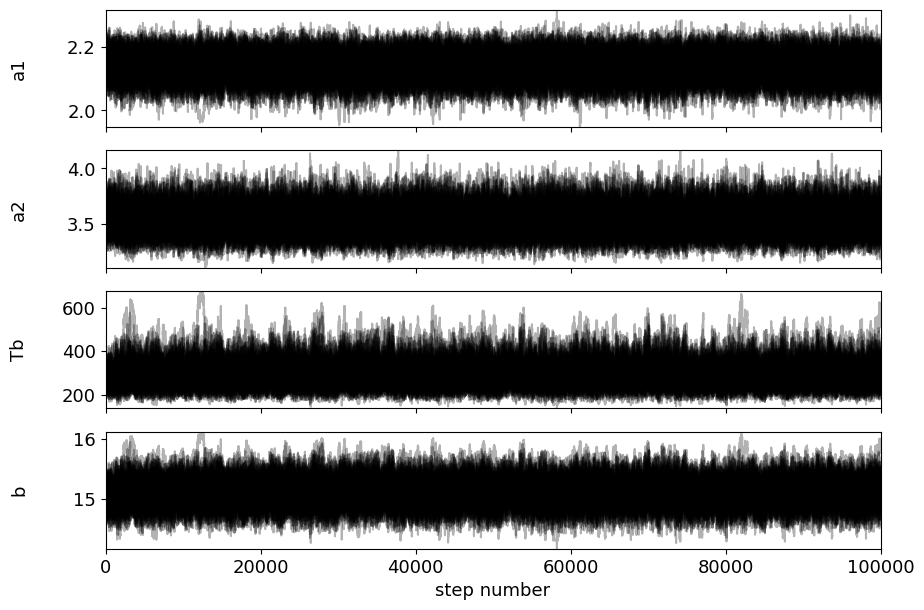

In [48]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a1", "a2", "Tb", "b"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylim(samples[:, :, i].min(), samples[:, :, i].max())


axes[-1].set_xlabel("step number");

Figure 9: This is a plot showing the paths of the walkers in the MCMC for all 4 parameters. Each parameter had 32 walkers, and they were all run for 100000 steps. The we gave the initial solution from the minimization to each of the walkers, and they stabilized near those values. As we can see, the walkers quickly stabilized and stayed stable for 100000 steps. The minimization and the MCMC found similar answers. The first 200 steps were discarded when analyzing as they include the burn in period.

In [49]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])
mcmc[:,1]

array([  2.1391077 ,   3.52344991, 284.30063167,  15.0937135 ])

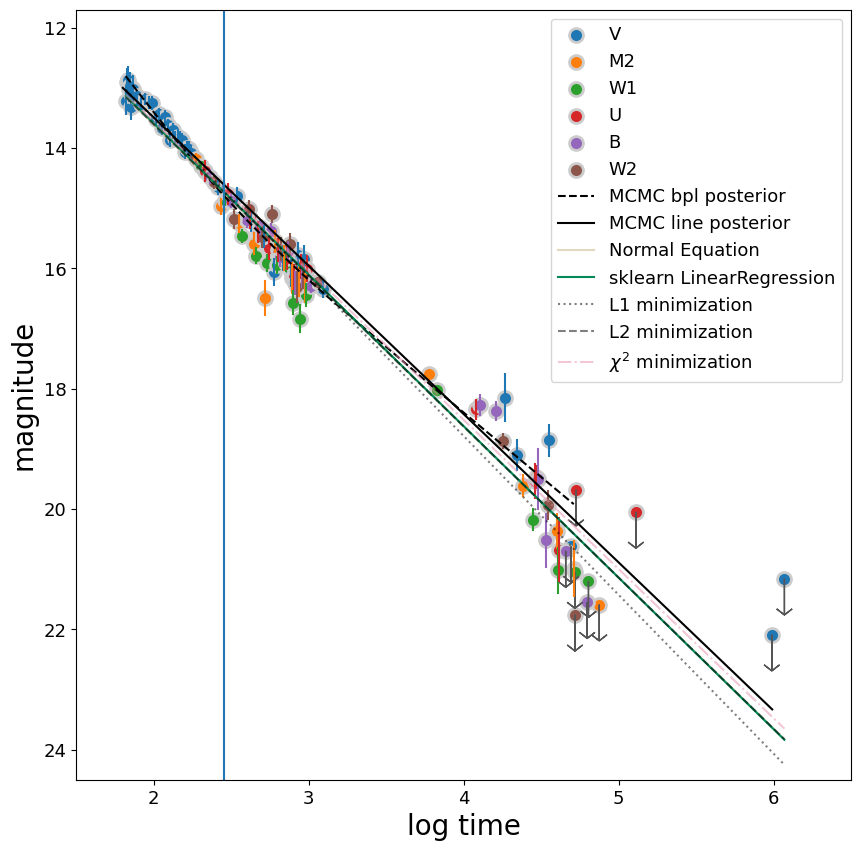

In [70]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

pl.plot(grbAGnouplim.logtime.values, bpl(mcmc[:,1], x_nolog), label="MCMC bpl posterior",  ls="--", c="k")

ax.plot(np.arange(1.8,6,0.01),
        line(mcmc_line[1][0], mcmc_line[0][0], np.arange(1.8,6,0.01)),
        ls="-", c="k",
        label="MCMC line posterior")

#ax.plot(grbAG.logtime.values, line(mcmcline[:,1][1], mcmc[:,1][0],
                            #grbAG.logtime.values), ls="--", c="k", label="MCMC")
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 10: This is a plot showing the GRB 052505A data, plotted with its associated error, same as in figure 1, 2 and 7. We have plotted several different models using various different ways to optimize the parameters. The different lines are labeled in the legend. The blue vertical line indicated the Tb in the BPL model, the black dashed line. As we can see, the bpl model is able to fit the data better overall, in  the early time and in the later time.

## plot the marginalized posterior distributions of the parameters

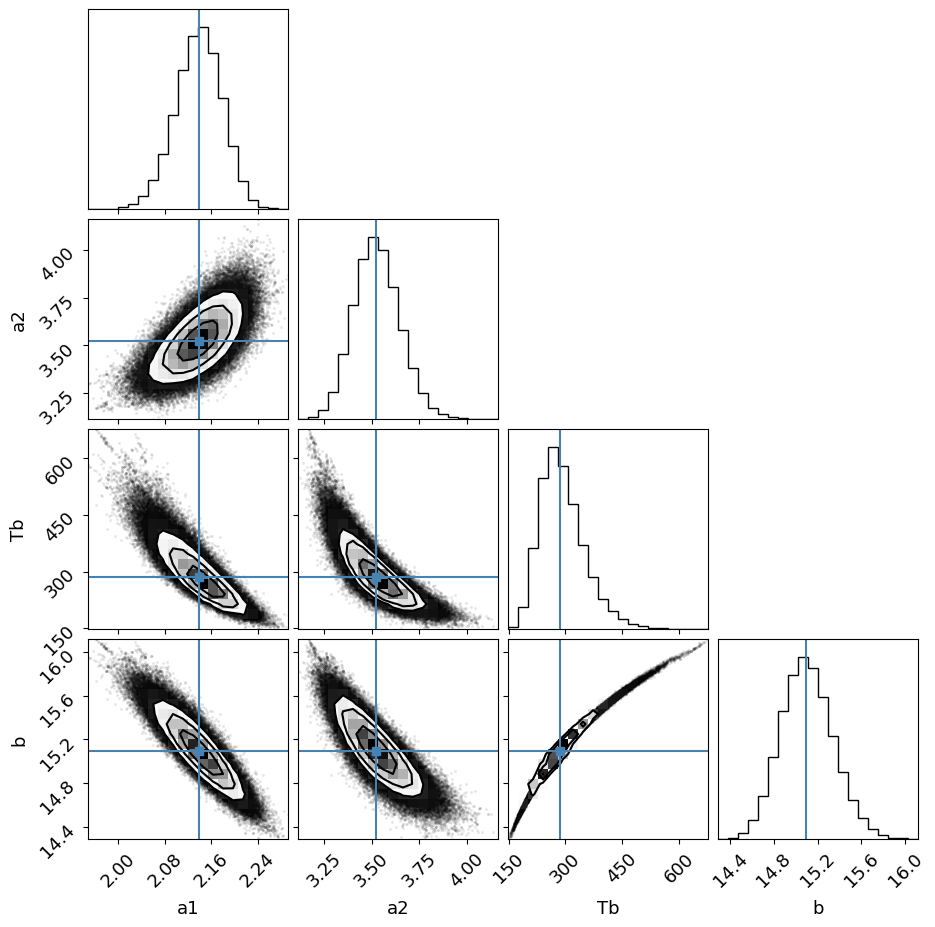

In [51]:

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc[:,1]);



Figure 11: These are the marginalized posterior distributions of the parameters. On the diagonal are histograms of the flat samples of each of the parameters. We can see that Tb is swewed to the left, and it is likely a real skew as the prior just prevents values below t min, 66, and above t max, 51257, so it would not prevent values below 150. The plots of the 2D distribution show where the most likely solution is. The black lines show diffeent amount of population. The outermost shows 84%, the next one 50% with the innermost showing 16%. What is interesting is that all of teh 2D plots show covarience, demonstrating that when one peramitter is changed, the other one changes aswell.

EXTRA CREDIT FOR 461 REQUIRED FOR 661

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in https://slides.com/d/Ql12kB4/live#/11. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)


- implement the calculation of the likelihood ration, which is expected to be chisq distributed following a chisq distribution with k degrees of freedom where k is the difference in number of parameters.

- implement the caluculation of the AIC (https://slides.com/d/Ql12kB4/live#/11/6
- and BIC (https://slides.com/d/Ql12kB4/live#/11/8)



In [52]:
print(f"The log likelihood of the MCMC linear line is {log_likelihood(mcmc_line[:,1], x, y, s):.2f}") #control the decimal digits!

The log likelihood of the MCMC linear line is -317.42


In [53]:
print(f"The log likelihood of the MCMC broken power law is {log_likelihood_bpl(mcmc[:,1], x_nolog, y, s):.2f}")

The log likelihood of the MCMC broken power law is -217.49


In [54]:
AICline = -2*log_likelihood(mcmc_line[:,1], x, y, s)/len(x) + 4/len(x)
print(f"The AIC of the MCMC linear line is {AICline:.2f}")

AICBPL = -2*log_likelihood_bpl(mcmc[:,1], x_nolog, y, s)/len(x_nolog) + 8/len(x_nolog)
print(f"The AIC of the MCMC broken power law is {AICBPL:.2f}")

The AIC of the MCMC linear line is 5.92
The AIC of the MCMC broken power law is 4.10


In [55]:
BICLine = -2*log_likelihood(mcmc_line[:,1], x, y, s) + np.log10(len(x))*2
print(f"The BIC of the MCMC linear line is {BICLine:.2f}")

BICBPL = -2*log_likelihood_bpl(mcmc[:,1], x_nolog, y, s) + np.log10(len(x_nolog))*4
print(f"The BIC of the MCMC broken power law is {BICBPL:.2f}")

The BIC of the MCMC linear line is 638.91
The BIC of the MCMC broken power law is 443.11


## Implement the likelihood ratio test printing out the likelihood ratio statistics https://slides.com/d/Ql12kB4/live#/11/2

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [56]:
def like_ratio_statistics(likehood1, likelihood2):
  return -2 * np.log(likehood1/likelihood2)

In [57]:
like_ratio_statistics(log_likelihood(mcmc_line[:,1], x, y, s), log_likelihood_bpl(mcmc[:,1], x_nolog, y, s))

np.float64(-0.7561576351839701)

# CHOOSE THE BEST MODEL IN THE NHRT FRAMEWORK


write out the first 4 steps of the NHRT:
- state the null
- state the alternative
- choose the threshold
- choose the test (OK, I did that for you!)
- measure the test statistics (pivotal quantity)
- get the p-value

_see if you can get the p-value from the table
I WILL NOT TAKE POINTS OFF IF YOU GET IT WRONG, but I want you to try and figure out how to read the table in https://slides.com/d/Ql12kB4/live#/11/2 to get a p-value out of your likelihood ratio statistics. Try your best!_

- use that p-value to see if you can or cannot reject the null and clearly state your conclusions



In [58]:
 #your work here
#H0
print("H0: The broken power law model does not provide significant improvement compared to the linear line model. ")

#H1
print("H1: The broken power law model provides a significant imporvement compared to the linear line model. ")

#Threshold
print("Threshold: The p value threshhold that we are setting is 0.05.")

#Test
print("In order to test this we will be using the AIC and BIC tests, and using the likelihood ratio")

#Test statistics
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(AICline, AICBPL))
print("BIC line {0:.2f} - BIC bpl {1:.2f}".format(BICLine, BICBPL))

#Likelihood ratio
print("The likelihood ratio is {0:.2f}".format(like_ratio_statistics(log_likelihood(mcmc_line[:,1], x, y, s), log_likelihood_bpl(mcmc[:,1], x_nolog, y, s))))

#P value from table comparison to our:
print("The likelihood ratio from the table is 0.103. Since our likelihood ratio is below this, it means that we can reject the null hypothesis.")



H0: The broken power law model does not provide significant improvement compared to the linear line model. 
H1: The broken power law model provides a significant imporvement compared to the linear line model. 
Threshold: The p value threshhold that we are setting is 0.05.
In order to test this we will be using the AIC and BIC tests, and using the likelihood ratio
AIC line 5.92 - AIC bpl 4.10
BIC line 638.91 - BIC bpl 443.11
The likelihood ratio is -0.76
The likelihood ratio from the table is 0.103. Since our likelihood ratio is below this, it means that we can reject the null hypothesis.


# your conclusions here

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [59]:
def aic(likelihood, N, df):
  return -2*likelihood/N + 2*df/N


def bic(likelihood, N, df):
  return  -2*likelihood + np.log10(N)*df


In [60]:
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(log_likelihood(mcmc_line[:,1], x, y, s), len(x), 2),
                                      aic(log_likelihood_bpl(mcmc[:,1], x_nolog, y, yerr), len(x_nolog), 4)))

print("BIC line {0:.2f} - BIC bpl {1:.2f}".format(bic(log_likelihood(mcmc_line[:,1], x, y, s), len(x), 2),
                                      bic(log_likelihood_bpl(mcmc[:,1], x_nolog, y, yerr), len(x_nolog), 4)))

AIC line 5.92 - AIC bpl 4.10
BIC line 638.91 - BIC bpl 443.11


# Extra Credit (Extra for everyone)
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model